# Biodiversity Intactness Index change in Phoenix, AZ
### Author: Austin Martinez
### GitHub Repository: https://github.com/austinmartinez12/urbanization-bii-mapping

## About Section

#### Purpose: 
The purpose of this project was to analyze the Biodiversity Interacts Index(BII) in the Phoenix, Arizona subdivision between 2017 and 2020. Specifically, this project aimed to identify and quantify the amount of area with a BII ≥ 0.75 in 2017 but experienced a decline by 2020. By visualizing this decline in BII, I can more clearly show the extent of biodiversity loss across the Phoenix subdivision.

#### Highlights: 
- Accessed and explored BII data from the Microsoft Planetary Computer STAC catalog
- Clipped BII rasters to match the extent of the Phoenix subdivision
- Calculated the percentage of area with BII ≥ 0.75
- Identified and Visualized areas that expiercned BII decline from 2017-2020

#### About the data:
- cb_2018_04_cousub_500k.shp: This cartographic boundary file is a simplified representation of Arizona's subdivisions. It was produced by the Census Bureau’s MAF/TIGER geographic database.
- Microsoft Planetary Computer STAC catalog: was generated by the Impact Observatory, in collaboration with Vizzuality, these datasets estimate terrestrial Biodiversity Intactness as 100-meter gridded maps for the years 2017-2020.

#### References:
- 1. U.S. Census Bureau. (2024, October 30). Cartographic boundary files – Shapefile. https://www.census.gov/geographies/mapping-files/time-series/geo/carto-boundary-file.html [Accessed Dec. 05, 2025]
- 2. Impact Observatory, Vizzuality, & Microsoft. (2025). Biodiversity Intactness: 100m gridded maps for 2017–2020 [Data set]. Microsoft Planetary Computer. https://planetarycomputer.microsoft.com/api/stac/v1/collections/io-biodiversity [Accessed Dec. 05, 2025]


## Loading in data

In [16]:
# Load in Libraries
import os
import pandas as pd
import geopandas as gpd
import xarray as xr
import rioxarray as rio
import matplotlib.pyplot as plt
import contextily as ctx
import planetary_computer
from geogif import gif
from pystac_client import Client 
import matplotlib.patches as patch



In [23]:
# Access MPC catalog
catalog = Client.open(
    "https://planetarycomputer.microsoft.com/api/stac/v1",
    modifier=planetary_computer.sign_inplace,
)


catalog.get_collections()
collections = list(catalog.get_collections()) # Turn generator into list

# Print the number of collections
print('Number of collections:', len(collections))

# Pull out the NAIP collection
naip_collection = catalog.get_child('naip')
print(naip_collection)

# Temporal range of interest during drought
time_range = '2017-01-01/2020-01-01'

# Bounding box containing phoenix
bbox =[-112.826843, 32.974108, -111.184387, 33.863574]

# Catalog search

# Get items from search
search = catalog.search(
    collections = ['io-biodiversity'],
    bbox = bbox,
    datetime = time_range)

# Determine number of items in search
items = search.item_collection()
print(len(items))

Number of collections: 126
<CollectionClient id=naip>
4


In [3]:
items

# Access the io-biodiversity collection from the Microsoft Planetary Computer STAC catalog to collect 2017 and 2020 rasters covering the Phoenix subdivision.
catalog = pystac_client.Client.open(
    "https://planetarycomputer.microsoft.com/api/stac/v1",
    modifier=planetary_computer.sign_inplace,
)

bbox_of_interest = [-112.826843, 32.974108, -111.184387, 33.863574]
search = catalog.search(collections=["io-biodiversity"], bbox=bbox_of_interest)

items = list(search.items())
for item in items:
    print(item)

asset_table = rich.table.Table("Asset Key", "Asset Title")
for key, value in items[-1].assets.items():
    asset_table.add_row(key, value.title)
asset_table

property_table = rich.table.Table("Property Name", "Property Value")
for key, value in sorted(items[-1].properties.items()):
    property_table.add_row(key, str(value))
property_table

stack = (
    stackstac.stack(items, bounds_latlon=bbox_of_interest, assets=["data"])
    .assign_coords(
        time=pd.to_datetime([item.properties["start_datetime"] for item in items])
        .tz_convert(None)
        .to_numpy()
    )
    .sortby("time")
)
stack.name = "Biodiversity Intactness"
stack

In [4]:
# Create a reproducible file path
az_path = os.path.join("data", "cb_2018_04_cousub_500k", "cb_2018_04_cousub_500k.shp")
# Read in census data for Arizona
az_subdiv = gpd.read_file(az_path)
# Select the Phoenix Subdivision
phoenix = az_subdiv[az_subdiv["NAME"] == "Phoenix"]

## Data analysis

#### Explore the data and write a brief summary of the information you obtained from the preliminary information.

In [44]:
# Print the total number of rasters
print(f"Total rasters returned: {len(items)}", "\n")

# print items to find where data is
print(f"Assets: {items[0].assets}", "\n")

# Print the CRS
print("CRS:", items[0].properties.get("proj:epsg"), "\n")

# Print raster bands
print("Raster bands:", items[0].assets["data"].extra_fields.get("raster:bands"))

Total rasters returned: 4 

Assets: {'data': <Asset href=https://pcdata01euw.blob.core.windows.net/impact/bii-v1/bii_2020/bii_2020_34.74464974521749_-115.38597824385106_cog.tif?st=2025-12-06T01%3A46%3A23Z&se=2025-12-07T02%3A31%3A23Z&sp=rl&sv=2025-07-05&sr=c&skoid=9c8ff44a-6a2c-4dfb-b298-1c9212f64d9a&sktid=72f988bf-86f1-41af-91ab-2d7cd011db47&skt=2025-12-04T18%3A38%3A08Z&ske=2025-12-11T18%3A38%3A08Z&sks=b&skv=2025-07-05&sig=hapogSp0W1spD7ihMwiN/Ixmgaf68UrNpNzwXbRZT4I%3D>, 'tilejson': <Asset href=https://planetarycomputer.microsoft.com/api/data/v1/item/tilejson.json?collection=io-biodiversity&item=bii_2020_34.74464974521749_-115.38597824385106_cog&assets=data&tile_format=png&colormap_name=io-bii&rescale=0%2C1&expression=0.97%2A%28data_b1%2A%2A3.84%29&format=png>, 'rendered_preview': <Asset href=https://planetarycomputer.microsoft.com/api/data/v1/item/preview.png?collection=io-biodiversity&item=bii_2020_34.74464974521749_-115.38597824385106_cog&assets=data&tile_format=png&colormap_name=io

After exploring the data I found that there are a total of 4 rasters. 1 for every year (2017-2020). After checking the item assets, I found that the data is in 'data'. The CRS is EPSG:4326, which is different the phoenix polygon's CRS. This will need to be resolved later on in the analysis.

Create a map showing the Phoenix subdivision within its broader geographic context. You may use any vector or raster datasets to create your map. Be sure to include citations or descriptions for these datasets at the top of your notebook too. You may also want to check out the contextily package to add a base map.

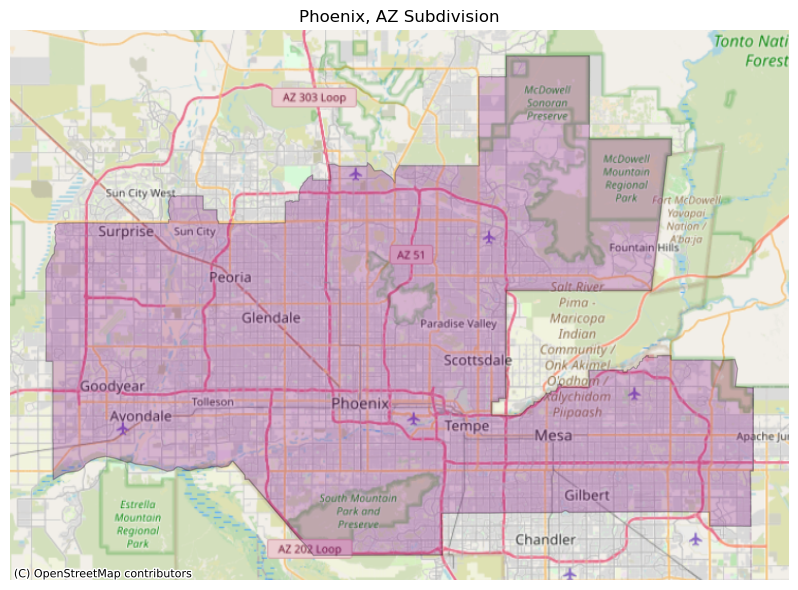

In [49]:

# Create a map showing the Phoenix subdivision within its broader geographic context
fig, ax = plt.subplots(1, 1, figsize=(9, 6))

# Add Phoenix, AZ Subdivision
phoenix.plot(ax=ax, facecolor='purple', edgecolor='black', linewidth=1, alpha=0.25)

# Add basemap using contextily
ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.Mapnik, crs = az_subdiv.crs)

# Add title
ax.set_title('Phoenix, AZ Subdivision')

# Remove axes
ax.axis('off')

# Display the map
plt.tight_layout()
plt.show()

Calculate the percentage of area of the Phoenix subdivision with a BII of at least 0.75 in 2017. Obtain the same calculation for 2020. Before you start coding, take a moment to write step-by-step instructions for yourself about how to get this result. You don’t need to include these in your notebook, but you should have a plan before starting your code.

In [50]:
# Select 2017 and 2020 rasters from search
item_2020 = items[0]
item_2017 = items[3]

# Extract 2017 and 2020 rasters using open_rasterio()
phx_2020 = rio.open_rasterio(item_2020.assets['data'].href)
phx_2017 = rio.open_rasterio(item_2017.assets['data'].href)


In [ ]:
# Match phoenix CRSs to phx_2020
phoenix = phoenix.to_crs(phx_2020.rio.crs)

# Clip 2017 and 2020 rasters to match phoenix shape
phx_2020_clip = phx_2020.rio.clip_box(*phoenix.total_bounds).rio.clip(phoenix.geometry)
phx_2017_clip = phx_2017.rio.clip_box(*phoenix.total_bounds).rio.clip(phoenix.geometry)



In [ ]:
# Identify values >= .75 in rasters
BII_75per_2020 = phx_2020_clip >= .75
BII_75per_2017 = phx_2017_clip >= .75

# Calculate the percent of area in each raster with BII ≥ 0.75
Bii_2020 = (BII_75per_2020.sum() / BII_75per_2020.count())*100
Bii_2017 = (BII_75per_2017.sum() / BII_75per_2017.count())*100

In [ ]:
# Find pixels that had a BII >= .75 in 2017 but not in 2020
Bii_lost_area = BII_75per_2017 & (~BII_75per_2020)

# Convert all 0 values to NAs if they don't meet the condition
Bii_lost_area_mask = Bii_lost_area.where(Bii_lost_area!=0)

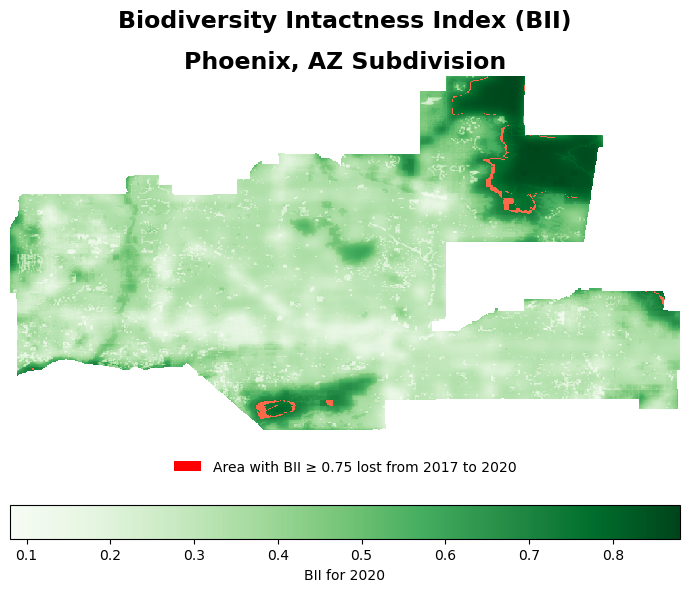

In [76]:
# Create a visualization showing the area with BII>=0.75 in 2017 that was lost by 2020
fig, ax = plt.subplots(figsize=(7, 6))

# Create choropleth map
phx_2020_clip.plot(cmap = 'Greens', cbar_kwargs={'location':'bottom', # Legend location
                                                 'label':'BII for 2020'})

Bii_lost_area_mask.plot(ax=ax, cmap='Reds', add_colorbar = False)

# Add title
plt.suptitle('Biodiversity Intactness Index (BII)', fontsize=17, weight = 'bold')

# Add subtitle
ax.set_title('Phoenix, AZ Subdivision', fontsize=17, weight='bold')

# Add legend of BII
legend_elements = [patch.Patch(facecolor='red', 
                         label='Area with BII ≥ 0.75 lost from 2017 to 2020')]

# Add a legend for BII loss
ax.legend(handles=legend_elements, loc='upper center', bbox_to_anchor=(0.5, -0.05), ncol=5, edgecolor = "white")

# Remove axes
ax.axis('off')

# Display the map
plt.tight_layout()
plt.show()

## Map Description

The map above shows the Biodiversity Intactness Index (BII) across the Phoenix, AZ subdivision(in green), and areas where BII was >= .75 in 2017 but droped in 2020(in red). These red ares are an indication that wild areas in the Phoenix region are decreasing in biodiversity compared to what would be expected in undisturbed ecosystems. This decline is most likley driven by fragmentation and urbanization.